Time series /home/sauser/qxw/data/nab/realKnownCause/ec2_request_latency_system_failure.csv (index 2) has timestamp duplicates. Kept first values.
Time series /home/sauser/qxw/data/nab/realKnownCause/machine_temperature_system_failure.csv (index 3) has timestamp duplicates. Kept first values.


count      4021
unique        2
top       False
freq       3417
Name: trainval, dtype: object
2014-03-14 03:31:00
2014-03-18 17:06:00
2014-03-20 21:26:00


<Axes: title={'center': 'ec2_request_latency_system_failure.csv'}>

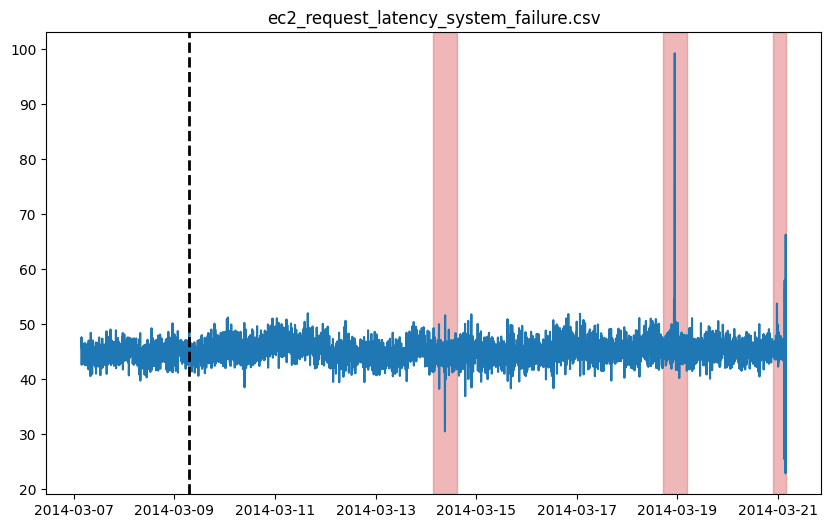

In [23]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from merlion.plot import plot_anoms
from merlion.utils import TimeSeries
from ts_datasets.anomaly import NAB

np.random.seed(1234)

# This is a time series with anomalies in both the train and test split.
# time_series and metadata are both time-indexed pandas DataFrames.
time_series,metadata,file = NAB(subset="realKnownCause")[2]
print(metadata.trainval.describe())
# Visualize the full time series
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
title=file.split("/")[-1]
ax.set_title(title)
# Label the train/test split with a dashed line & plot anomalies
ax.axvline(metadata[metadata.trainval].index[-1], ls="--", lw=2, c="k")
plot_anoms(ax, TimeSeries.from_pd(metadata.anomaly))

In [33]:
|from merlion.utils import TimeSeries

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

In [34]:
#init models
from anomaly import init_model
model1,model2,model3,ensemble=init_model()

In [35]:
from merlion.evaluate.anomaly import TSADMetric

# Train IsolationForest in the default way, using the ground truth anomaly labels
# to set the post-rule's threshold
print(f"Training {type(model1).__name__}...")
train_scores_1 = model1.train(train_data=train_data, anomaly_labels=train_labels)

# Train WindStats completely unsupervised (this retains our anomaly detection
# default anomaly detection threshold of 4)
print(f"\nTraining {type(model2).__name__}...")
train_scores_2 = model2.train(train_data=train_data, anomaly_labels=None)

# Train Prophet with the ground truth anomaly labels, with a post-rule
# trained to optimize Precision score
print(f"\nTraining {type(model3).__name__}...")
post_rule_train_config_3 = dict(metric=TSADMetric.F1)
train_scores_3 = model3.train(
    train_data=train_data, anomaly_labels=train_labels,
    post_rule_train_config=post_rule_train_config_3)

# We consider an unsupervised ensemble, which combines the anomaly scores
# returned by the models & sets a static anomaly detection threshold of 3.
print("\nTraining ensemble...")
ensemble_post_rule_train_config = dict(metric=None)
train_scores_e = ensemble.train(
    train_data=train_data, anomaly_labels=train_labels,
    post_rule_train_config=ensemble_post_rule_train_config,
)

print("Done!")

Training IsolationForest...

Training WindStats...

Training ProphetDetector...


15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing



Training ensemble...


15:44:12 - cmdstanpy - INFO - Chain [1] start processing
15:44:12 - cmdstanpy - INFO - Chain [1] done processing


Done!


In [39]:
from anomaly import model_infer
#model1
scores_1,labels_1 =model_infer(model1,test_data)
#model2
scores_2,labels_2=model_infer(model2,test_data)
#model3
scores_3,labels_3=model_infer(model3,test_data)
#ensemble
scores_e ,labels_e=model_infer(ensemble,test_data)

IsolationForest.get_anomaly_score() nonzero values (raw)
                     anom_score
time                           
2013-12-14 16:55:00    0.424103
2013-12-14 17:00:00    0.418938
2013-12-14 17:05:00    0.484891
2013-12-14 17:10:00    0.500257
2013-12-14 17:15:00    0.449213
...                         ...
2014-02-19 15:05:00    0.419456
2014-02-19 15:10:00    0.415807
2014-02-19 15:15:00    0.406724
2014-02-19 15:20:00    0.427094
2014-02-19 15:25:00    0.428348

[19279 rows x 1 columns]

IsolationForest.get_anomaly_label() nonzero values (post-processed)
                     anom_score
time                           
2013-12-16 16:00:00    3.251397
2013-12-16 18:35:00    3.681691
2013-12-27 19:25:00    3.914430
2013-12-27 23:20:00    3.260543
2013-12-28 04:15:00    3.738462
2013-12-28 06:20:00    3.303482
2014-01-02 10:00:00    3.233514
2014-01-05 17:50:00    3.791805
2014-01-12 09:25:00    3.535895
2014-01-13 10:05:00    3.314500
2014-01-16 12:50:00    3.850349
2014-01-24 12:50

In [41]:
from anomaly import qa_evalution
model_labels=[(model1, labels_1), (model2, labels_2), (model3, labels_3), (ensemble, labels_e)]
qa_evalution(model_labels,test_labels)

IsolationForest
Precision: 0.1667
Recall:    1.0000
F1:        0.2857
MTTD:      0 days 23:31:40

WindStats
Precision: 0.0270
Recall:    1.0000
F1:        0.0526
MTTD:      0 days 12:01:40

ProphetDetector
Precision: 0.2143
Recall:    1.0000
F1:        0.3529
MTTD:      1 days 00:03:20

DetectorEnsemble
Precision: 0.3333
Recall:    0.6667
F1:        0.4444
MTTD:      1 days 10:22:30



IsolationForest
2013-12-15 17:50:00
2014-01-27 14:20:00
2014-02-07 14:55:00


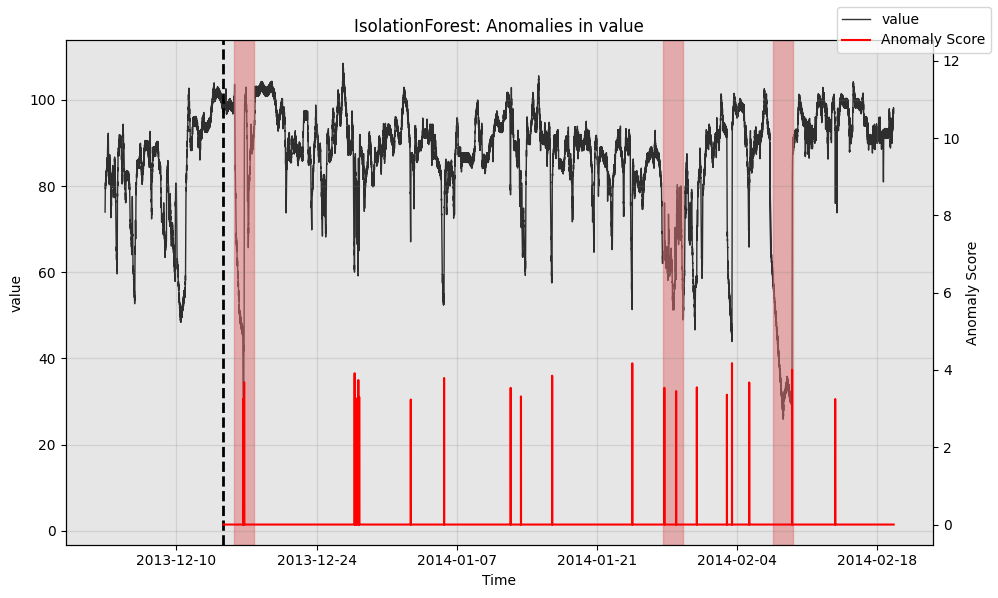


WindStats
2013-12-15 17:50:00
2014-01-27 14:20:00
2014-02-07 14:55:00


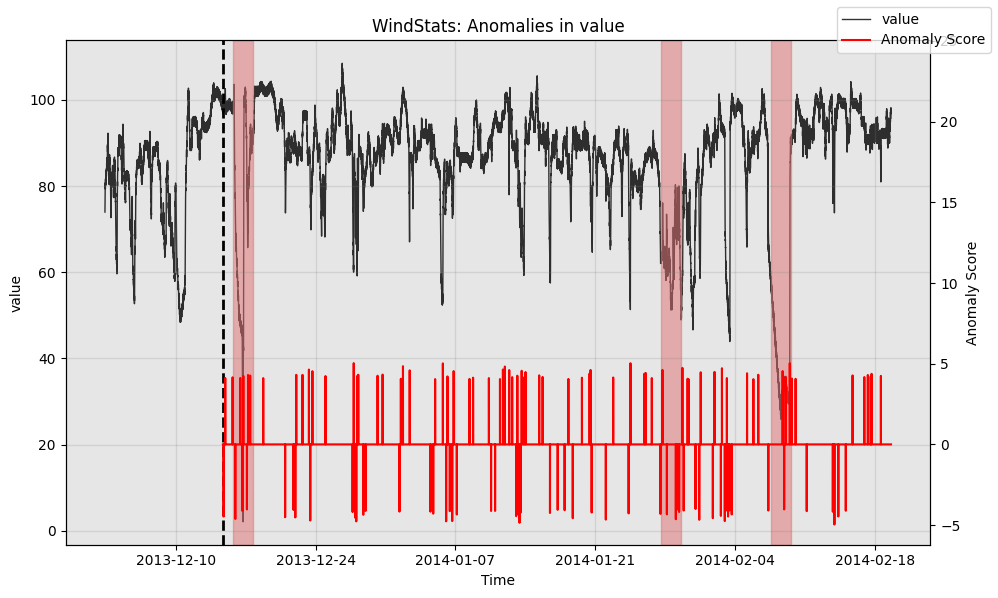


ProphetDetector
2013-12-15 17:50:00
2014-01-27 14:20:00
2014-02-07 14:55:00


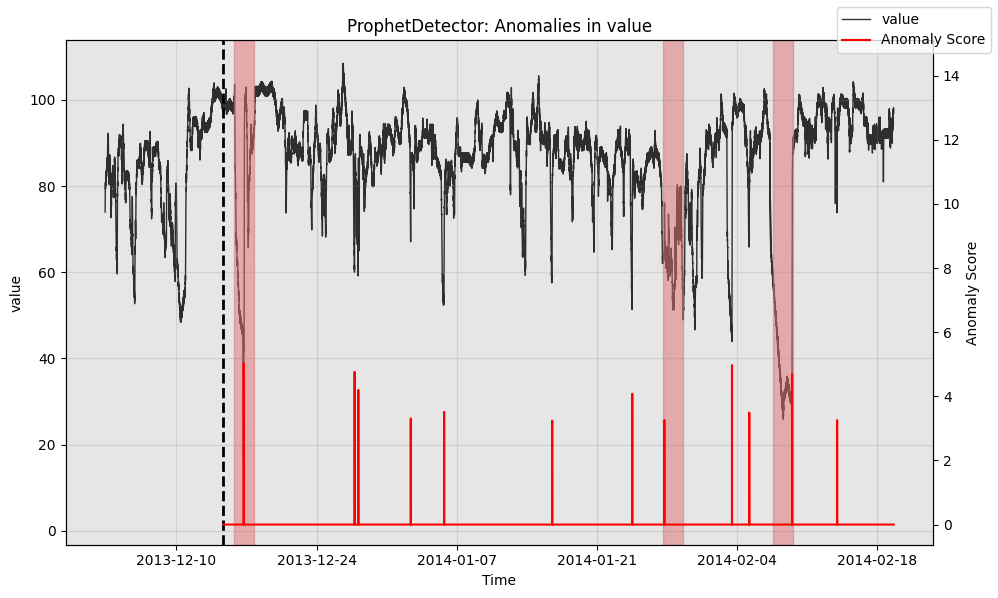

In [43]:
#model visualization
#filter_scores=True:the post-processed anomaly scores
#filter_scores=False:the raw anomaly scores
for model in [model1, model2, model3]:
    print(type(model).__name__)
    fig, ax = model.plot_anomaly(
        time_series=test_data, time_series_prev=train_data,
        filter_scores=True, plot_time_series_prev=True)
    plot_anoms(ax=ax, anomaly_labels=test_labels)
    plt.show()
    print()

2013-12-15 17:50:00
2014-01-27 14:20:00
2014-02-07 14:55:00


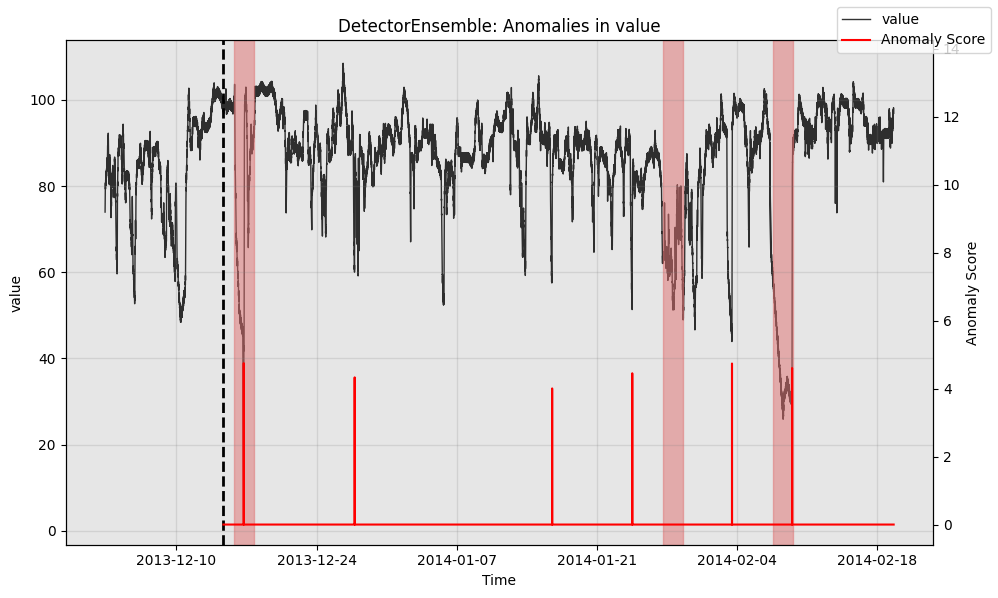

In [45]:
fig, ax = ensemble.plot_anomaly(
    time_series=test_data, time_series_prev=train_data,
    filter_scores=True, plot_time_series_prev=True)
plot_anoms(ax=ax, anomaly_labels=test_labels)
plt.show()

In [46]:
    # Initialize the evaluator
    from merlion.evaluate.anomaly import TSADEvaluator, TSADEvaluatorConfig
    evaluator = TSADEvaluator(model=model, config=TSADEvaluatorConfig(retrain_freq="7d"))
    # The kwargs we would provide to ensemble.train() for the initial training
    # Note that we are training the ensemble unsupervised.
    train_kwargs = {"anomaly_labels": None}

    # We will use the default kwargs for re-training (these leave the
    # post-rules unchanged, since there are no new labels)
    retrain_kwargs = None

    # We call evaluator.get_predict() to get the time series of anomaly scores
    # produced by the anomaly detector when deployed in this manner
    train_scores, test_scores = evaluator.get_predict(
        train_vals=train_data, test_vals=test_data,
        train_kwargs=train_kwargs, retrain_kwargs=retrain_kwargs
    )
    # Now let's evaluate how we did.
    precision = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.Precision)
    recall = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.Recall)
    f1 = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.F1)
    mttd = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.MeanTimeToDetect)
    print("Ensemble Performance")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"MTTD:      {mttd}")
    print()

16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:36:37 - cmdstanpy - INFO - Chain [1] done processing
TSADEvaluator:  10%|█         | 604800/5783700 [00:00<00:01, 3349307.23it/s]16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:36:38 - cmdstanpy - INFO - Chain [1] done processing
TSADEvaluator:  21%|██        | 1209600/5783700 [00:00<00:04, 1126453.39it/s]16:36:38 - cmdstanpy - INFO - Chain [1] start processing
16:36:39 - cmdstanpy - INFO - Chain [1] done processing
TSADEvaluator:  31%|███▏      | 1814400/5783700 [00:02<00:05, 708018.76it/s] 16:36:40 - cmdstanpy - INFO - Chain [1] start processing
16:36:40 - cmdstanpy - INFO - Chain [1] done processing
TSADEvaluator:  42%|████▏     | 2419200/5783700 [00:03<00:05, 650180.01it/s]16:36:41 - cmdstanpy - INFO - Chain [1] start processing
16:36:42 - cmdstanpy - INFO - Chain [1] done processing
TSADEvaluator:  52%|█████▏    | 3024000/5783700 [00:05<00:05, 480452.32it/s]16:36:43 - cmdstanpy - INFO - Chain [1] start process

Ensemble Performance
Precision: 0.1818
Recall:    0.6667
F1:        0.2857
MTTD:      1 days 10:22:30

